# CSC 215 - Final Project

# Gender Classification with Deep Learning

## Khoi Hoang

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Helper function
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Manually load images

In [3]:
IMAGES_DIRECTORY = "C:/Users/hgdan/Downloads/lfw-deepfunneled/"

In [4]:
people = os.listdir(path=IMAGES_DIRECTORY)
print("There are {} people in the full lfw dataset.".format(len(people)))

There are 5749 people in the full lfw dataset.


In [5]:
image_array = []
for directory in os.listdir(IMAGES_DIRECTORY):
    image_dir = IMAGES_DIRECTORY + directory #go to sub directories
    for image in os.listdir(image_dir):
        image = plt.imread(os.path.join(image_dir, image))
        #image = cv2.resize(image, (100, 100))
        image_array.append(image)

In [6]:
image_array = np.array(image_array)
image_array.shape

(13233, 250, 250, 3)

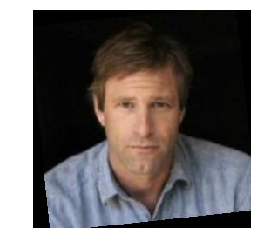

In [41]:
sample = 0

each = image_array[sample]

plt.figure()
plt.axis('off')
plt.imshow(each)
plt.show()

#### Making the gender labels for the output

In [10]:
df_male = pd.read_csv("gender_labels/male_names.txt")
df_female = pd.read_csv("gender_labels/female_names.txt")

In [11]:
df_female.head()

,Pics
0,Claudia_Coslovich_0001.jpg
1,Allison_Searing_0001
2,Elizabeth_Hill_0001.jpg
3,Erika_Reyes_0001.jpg
4,Tatiana_Shchegoleva_0001.jpg


In [12]:
# Helper function to convert the df into list of names for males or females
def gender_to_list(df):
    temp = df.values
    temp = temp.reshape(temp.shape[0],)
    
    res = []
    for each in temp:
        each = each.rsplit('_', 1)[0]
        res.append(each)
    
    return res

In [13]:
male = gender_to_list(df_male)
female = gender_to_list(df_female)

In [14]:
female[0:5]

['Claudia_Coslovich',
 'Allison_Searing',
 'Elizabeth_Hill',
 'Erika_Reyes',
 'Tatiana_Shchegoleva']

In [15]:
gender_target = []
for each in os.listdir(IMAGES_DIRECTORY): #iterate through the subdir
    if each in male:
        for i in range(len(os.listdir(IMAGES_DIRECTORY + each))):
            gender_target.append('male')
    elif each in female:
        for i in range(len(os.listdir(IMAGES_DIRECTORY + each))):
            gender_target.append('female')
    else:
        print(each)

In [16]:
gender_target = np.array(gender_target)
gender_target.shape

(13233,)

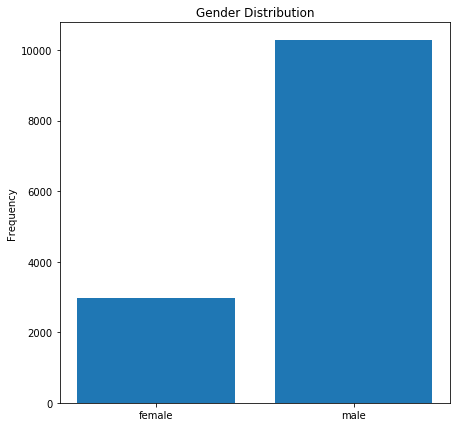

In [17]:
label, count_gender = np.unique(gender_target, return_counts=True)
y_pos = np.arange(2)
plt.figure(figsize=(7,7))
plt.bar(y_pos, count_gender, align='center')
plt.title("Gender Distribution")
plt.xticks(y_pos, label)
plt.ylabel("Frequency")
plt.show()

As we can see in the graph, the data is highly imbalanced. There are two ways to deal with imbalanced data:
  * Undersampling, we can reduce the number of male images to roughly 3k to balance the number of female images. However, this is not ideal because bigger data helps CNN train better
  * Oversampling, which is the technique I will apply in this project, is to increase the samples of imbalanced data. I will apply image augmentation on the female images to balance the male images

# Data balancing and Image Augmentation

In [91]:
female_images = []
male_images = []
for i in range(len(gender_target)):
    if gender_target[i] == 'female':
        female_images.append(image_array[i])
    else:
        male_images.append(image_array[i])
        
female_images = np.array(female_images)
male_images = np.array(male_images)
print(female_images.shape)
print(male_images.shape)

(2962, 250, 250, 3)
(10271, 250, 250, 3)


In [92]:
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

i=0
for batch in img_gen.flow(female_images, batch_size=1, 
                          save_to_dir="augmented",
                          save_format='jpg'):
    i+=1
    if i==7309:
        break
    

In [93]:
# read new augmented images
augmented_images = []
for image in os.listdir('augmented'):
    image = plt.imread(os.path.join('augmented/', image))
    augmented_images.append(image)

In [94]:
augmented_images = np.array(augmented_images)

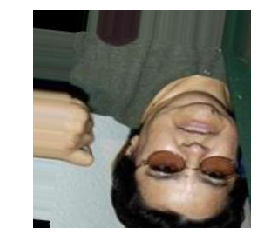

In [95]:
plt.figure()
plt.axis('off')
plt.imshow(augmented_images[0])
plt.show()

In [96]:
female_images = np.concatenate((female_images, augmented_images), axis=0)
female_images.shape

(10271, 250, 250, 3)

In [97]:
print("Number of male images: {}".format(male_images.shape[0]))
print("Number of female images: {}".format(female_images.shape[0]))

Number of male images: 10271
Number of female images: 10271


In [99]:
input_images = np.concatenate((male_images, female_images), axis=0)
output_label = np.zeros(input_images.shape[0])

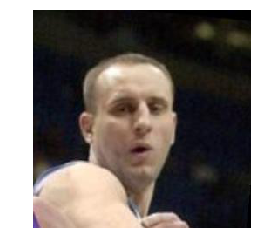

In [103]:
plt.figure()
plt.axis('off')
plt.imshow(input_images[10270])
plt.show()

In [104]:
# the first half is 0 (males), second half is 1 (females)
output_label[10271:] = 1

In [113]:
# Resize the images
input_images_resized = []
for each in input_images:
    each = cv2.resize(each, (100, 100))
    input_images_resized.append(each)

input_images_resized = np.array(input_images_resized)
input_images_resized.shape

(20542, 100, 100, 3)

# Deep CNN model

In [107]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, regularizers
from sklearn import metrics
from keras.optimizers import Adam

In [114]:
x_train, x_test, y_train, y_test = train_test_split(input_images_resized, output_label, test_size=0.2, random_state=43)
#x_train, x_test, y_train, y_test = train_test_split(lfw_people.images, y, test_size=0.2, random_state=43)

In [115]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16433, 100, 100, 3)
(16433,)
(4109, 100, 100, 3)
(4109,)


In [126]:
np.unique(y_test, return_counts=True)

(array([0., 1.], dtype=float32), array([4109, 4109], dtype=int64))

In [117]:
# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [118]:
y_train

array([1., 0., 1., ..., 1., 1., 1.])

In [119]:
# Label encode the gender
#le = preprocessing.LabelEncoder()
#y_train = le.fit_transform(y_train)
#y_test = le.fit_transform(y_test)

In [120]:
# One hot encode the gender
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [121]:
y_test[0:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [123]:
checkpointer = ModelCheckpoint(filepath="save/deepcnn.hdf5", verbose=0, save_best_only=True) # save best model
#input_shape = (250, 250, 3)
input_shape = (100, 100, 3)
learning_rate = 0.001

#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.25)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train,y_train, validation_split=0.2, callbacks=[monitor,checkpointer],verbose=1,epochs=50, batch_size=64, shuffle=True)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
print('Training finished...Loading the best model')  
print()
model.load_weights('save/deepcnn.hdf5') # load weights from best model

Train on 13146 samples, validate on 3287 samples
Epoch 1/50
13146/13146 [==============================] - 33s 3ms/step - loss: 0.4900 - acc: 0.7586 - val_loss: 0.2769 - val_acc: 0.8728
Epoch 2/50
13146/13146 [==============================] - 29s 2ms/step - loss: 0.2767 - acc: 0.8730 - val_loss: 0.2957 - val_acc: 0.8521
Epoch 3/50
13146/13146 [==============================] - 30s 2ms/step - loss: 0.2235 - acc: 0.9009 - val_loss: 0.2167 - val_acc: 0.9078
Epoch 4/50
13146/13146 [==============================] - 30s 2ms/step - loss: 0.1934 - acc: 0.9208 - val_loss: 0.1722 - val_acc: 0.9294
Epoch 5/50
13146/13146 [==============================] - 29s 2ms/step - loss: 0.1601 - acc: 0.9328 - val_loss: 0.1414 - val_acc: 0.9462
Epoch 6/50
13146/13146 [==============================] - 30s 2ms/step - loss: 0.1359 - acc: 0.9434 - val_loss: 0.1366 - val_acc: 0.9504
Epoch 7/50
13146/13146 [==============================] - 30s 2ms/step - loss: 0.1213 - acc: 0.9498 - val_loss: 0.1389 - val_acc:

In [124]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 96)        2688      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 96)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 49, 49, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 49, 49, 256)       221440    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 512)       1180160   
__________

-----------------**Convolutional Neural Network Report**---------------

F1 score: 0.950345167263125
Accuracy score: 0.9503528839133609
Confusion matrix: 
 [[1973   70]
 [ 134 1932]]
Plotting confusion matrix


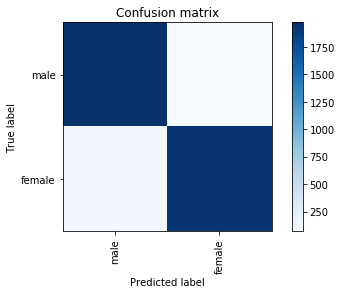

             precision    recall  f1-score   support

          0       0.94      0.97      0.95      2043
          1       0.97      0.94      0.95      2066

avg / total       0.95      0.95      0.95      4109



In [130]:
cnn_pred = model.predict(x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)
y_true = np.argmax(y_test,axis=1)

cnn_f1 = metrics.f1_score(y_true, cnn_pred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(y_true, cnn_pred)
cnn_cm = metrics.confusion_matrix(y_true, cnn_pred)
printmd("-----------------**Convolutional Neural Network Report**---------------")
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Confusion matrix: \n", cnn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, ["male", "female"])
plt.show()

print(metrics.classification_report(y_true, cnn_pred))

In [129]:
np.unique(y_true, return_counts=True)

(array([0, 1], dtype=int64), array([2043, 2066], dtype=int64))

# Principal Component Analysis (PCA)

In [3]:
IMAGES_DIRECTORY = "C:/Users/hgdan/Downloads/lfw-deepfunneled/"

In [4]:
people = os.listdir(path=IMAGES_DIRECTORY)
print("There are {} people in the full lfw dataset.".format(len(people)))

There are 5749 people in the full lfw dataset.


In [5]:
image_array = []
for directory in os.listdir(IMAGES_DIRECTORY):
    image_dir = IMAGES_DIRECTORY + directory #go to sub directories
    for image in os.listdir(image_dir):
        image = plt.imread(os.path.join(image_dir, image))
        image = cv2.resize(image, (100, 100))
        image_array.append(image)

In [6]:
image_array = np.array(image_array)
image_array.shape

(13233, 100, 100, 3)

In [7]:
image_array_pca = image_array.reshape(image_array.shape[0], 100*100*3)
image_array_pca.shape

(13233, 30000)

In [8]:
from sklearn.decomposition import PCA

# fit the PCA with the original images
pca = PCA().fit(image_array_pca)

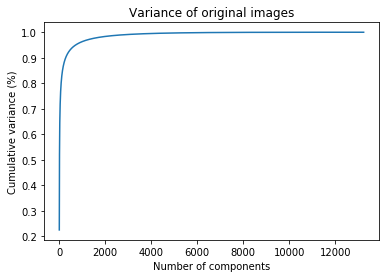

In [9]:
# Plot the cumulative sum of variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance (%)') #for each component
plt.title('Variance of original images')
plt.show()

The Variance graph showed that by using around 2000 components, we can retain approximately 97% of the data

In [9]:
pca = PCA(n_components=2000)
input_pca = pca.fit_transform(image_array_pca)

In [10]:
input_pca.shape

(13233, 2000)

# SVM model

In [20]:
x_train, x_test, y_train, y_test = train_test_split(input_pca, gender_target, test_size=0.2, random_state=43)

In [21]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10586, 2000)
(10586,)
(2647, 2000)
(2647,)


In [22]:
# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

In [23]:
y_train

array(['male', 'male', 'male', ..., 'male', 'male', 'male'], dtype='<U6')

In [24]:
# Label encode the gender
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [25]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([ 585, 2062], dtype=int64))

In [26]:
from sklearn.svm import SVC

svc = SVC(kernel='poly', gamma='auto')
svc.fit(x_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

-----------------**SVM Report**---------------

F1 score: 0.8501550300747599
Accuracy score: 0.8587079712882508
Confusion matrix: 
 [[ 318  267]
 [ 107 1955]]
Plotting confusion matrix


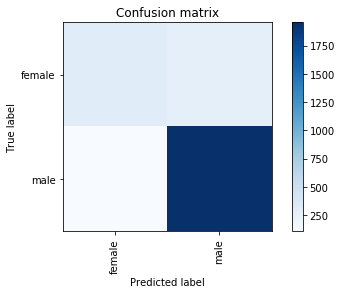

              precision    recall  f1-score   support

           0       0.75      0.54      0.63       585
           1       0.88      0.95      0.91      2062

   micro avg       0.86      0.86      0.86      2647
   macro avg       0.81      0.75      0.77      2647
weighted avg       0.85      0.86      0.85      2647



In [31]:
y_pred_svc = svc.predict(x_test)
svc_f1 = metrics.f1_score(y_test, y_pred_svc, average= "weighted")
svc_accuracy = metrics.accuracy_score(y_test, y_pred_svc)
svc_cm = metrics.confusion_matrix(y_test, y_pred_svc)
printmd("-----------------**SVM Report**---------------")
print("F1 score: {}".format(svc_f1))
print("Accuracy score: {}".format(svc_accuracy))
print("Confusion matrix: \n", svc_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(svc_cm, ['female', 'male'])
plt.show()

print(metrics.classification_report(y_test, y_pred_svc))